# torch.autograd를 사용한 자동 미분
- 신경망을 학습할 때 가장 자주 사용되는 알고리즘은 역전파이다.
- 이 알고리즘에서, 매개변수(model의 weight)는 주어진 매개변수에 대한 손실 함수의 변화도(gradient)에 따라 조정된다.
- 이러한 변화도를 계산하기 위해 파이토치에는 `torch.autograd`라고 불리는 자동 미분 엔진이 내장되어 있다.(이는 모든 계산 그래프에 대한 변화도의 자동 계산을 지원한다.)
- 입력 `x`, 매개변수 `w`와 `b`, 그리고 일부 손실 함수가 있는 가장 간단한 단일 계층 신경망을 가정하겠다. 파이토치에서는 다음과 같이 정의할 수 있다.

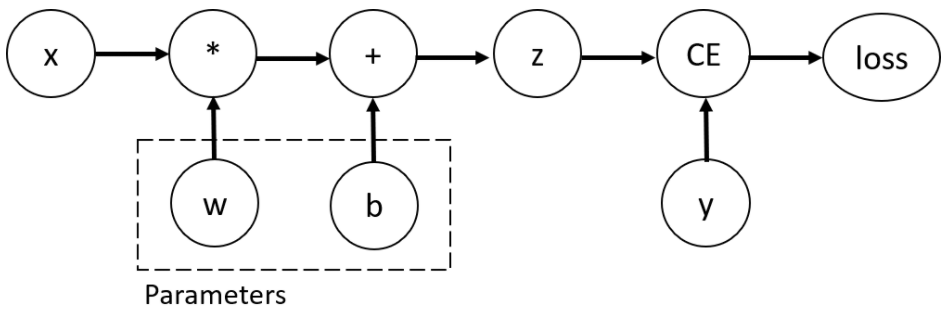

In [9]:
import torch

x = torch.ones(5) # input tensor
y = torch.zeros(3) # expected output

w = torch.randn(5, 3, requires_grad = True) # requires_grad의 값은 텐서를 생성할 때 설정하거나, 나중에 x.requires_grad_(True) 메소드를 사용하여 설정할 수도 있다.
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [10]:
"""위 신경망에서 w와 b는 최적화 해야 하는 매개변수이다.
따라서 이런 변수들에 대한 손실 함수의 변화도를 계산할 수 있어야 한다.
이를 위해서 해당 텐서에 requires_grad 속성을 설정한다."""

"""역전파 전파 함수에 대한 참조(reference)는 텐서의 grad_fn 속성에 저장된다. """
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x000002A426B02188>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward object at 0x000002A426B02148>


---------------

### 변화도(gradient) 계산하기
- 신경망에서 매개변수의 가중치를 최적화하려면 매개변수에 대한 손실함수의 도함수(derivative)를 계산해야 한다.
- 즉, `x와 y의 일부 고정값에서 각 매개변수들로 loss 값을 미분한 값이 필요하다.` 
- 이러한 도함수를 계산하기 위해 loss.backward()를 호출한 다음 `w.grad`와 `b.grad`에서 값을 가져온다.
- loss.backward()는 역전파를 수행하라는 코드이다. 

In [11]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1104, 0.1693, 0.0850],
        [0.1104, 0.1693, 0.0850],
        [0.1104, 0.1693, 0.0850],
        [0.1104, 0.1693, 0.0850],
        [0.1104, 0.1693, 0.0850]])
tensor([0.1104, 0.1693, 0.0850])


In [14]:
"""연산 그래프의 잎(leaf) 노드들 중 requires_grad 속성이 True로 설정된 노드들의 grad 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가 유효하지 않습니다."""

'연산 그래프의 잎(leaf) 노드들 중 requires_grad 속성이 True로 설정된 노드들의 grad 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가 유효하지 않습니다.'

-----

### 변화도 추적 멈추기
- 기본적으로 requires_grad=True인 모든 텐서들은 연산 기록을 추적하고 변화도 계산을 지원한다.
- 모델을 학습한 뒤, 입력 데이터를 단순히 적용하기만 할 경우와 같이 순전파 연산만 필요한 경우네는, 이러한 추적이나 지원이 필요없을 수 있다.
- 연산 코드를 torch.no_grad() 블록으로 둘러싸서 연산 추적을 멈출 수 있다.

In [15]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

"""with문은 자원을 획득하고 사용 후, 반납해야 하는 경우 주로 사용한다."""
## torch.no_grad()로 둘러싸면 requires_grad=False가 된다.
with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [16]:
"""동일한 결과를 얻는 다른 방법은 텐서에 detach() 메소드를 사용하는 것이다."""
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


#### 변화도 추적을 멈춰야 하는 이유
1. 신경망의 일부 매개변수를 고정된 매개변수로 표시 (이는 사전 학습된 신경망을 미세조정 할 때 매우 일반적인 시나리오이다.
2. 변화도를 추적하지 않는 텐서의 연산이 더 효율적이기 때문에, 순전파 단계만 수행할 때 (inference를 할 때) 연산 속도가 향상된다.

#### .backward()에 인자를 넣어줘야 하는 경우
- 각 tensor는 .grad_fn 속성을 갖고 있는데, 이는 Tensor를 생성한 Function을 참조하고 있다. 
- 도함수를 계산하기 위해서는 Tensor의 .backward()를 호출하면 된다.
- `만약 Tensor가 scalar인 경우에는 backward에 인자값을 지정해줄 필요가 없다. 하지만 여러 개의 요소를 갖고 있을 때에는 tensor를 지정해줘야한다.`
    - 파이토치에서는 계산된 목적함수의 loss 값에 backward() 함수를 계산하면 모델을 구성하는 파라미터에 대한 gradient를 계산한다.
    - backward() 메소드는 암묵적으로 loss 값이 벡터가 아닌 scalar 라고 가정하여 최종 loss 값에 대한 평균이나 합을 통해 벡터를 하나의 scalar 값으로 만들어 주어야 한다.
    - 즉, backward(torch.tensor[1], dtype=torch.float)이 디폴트로 설정되어 있음
    - 따라서 loss 값이 scalar가 아닌 vector라면 `y.backward(torch.ones_like(x), retain_graph=True)` 다음과 같이 설정해줘야한다.
        - retain_graph=True는 중간 기울기들이 사라지지 않게 해주는 것이다.


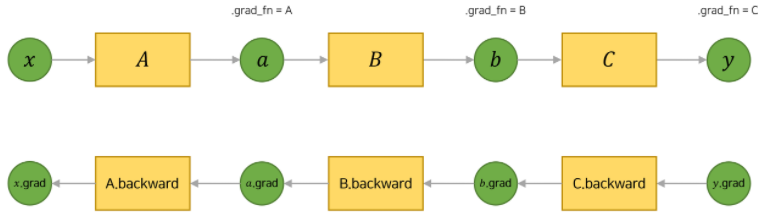

In [96]:
"""파이토치 backward 인자 알아보기"""
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(x)
print(y)

tensor([-0.6610,  1.3232,  0.0371], requires_grad=True)
tensor([-676.8461, 1354.9585,   38.0050], grad_fn=<MulBackward0>)


In [98]:
## 이와같이 입력 벡터 값을 backward에 인자로 주어서 계산
y.backward(torch.ones_like(x), retain_graph=True)

print(x.grad)

tensor([2048., 2048., 2048.])
